In [37]:
import pandas as pd
import numpy as np
import plotly
import chart_studio.plotly as py
import chart_studio
import matplotlib.pyplot as plt

chart_studio.tools.set_credentials_file(username='oystein.nerva', api_key='0ODcZ6UisJ8n0AjEQt9N')

In [425]:
url = "https://github.com/NRVA/COVID19_Norge/raw/master/COVID19_fhi_data_fylke.csv"
data = pd.read_csv(url, sep=';')
data

,Fylke,09-Mar-20,10-Mar-20,11-Mar-20,12-Mar-20,13-Mar-20,14-Mar-20,15-Mar-20,16-Mar-20,17-Mar-20,18-Mar-20,19-Mar-20,20-Mar-20,21-Mar-20,22-Mar-20,23-Mar-20
0,Agder,19,19,20,32,34,52,55,67,67,67,75,79,82,91,91
1,Innlandet,16,16,23,40,49,57,72,81,88,97,105,115,125,148,151
2,Møre og Romsdal,5,5,7,6,7,16,20,20,20,20,25,29,32,38,44
3,Nordland,3,3,3,4,5,8,8,11,11,12,13,17,17,19,18
4,Oslo,51,51,123,166,207,222,281,292,329,348,392,419,448,523,636
5,Rogaland,33,33,71,82,105,119,127,131,150,161,176,180,199,219,237
6,Troms og Finnmark,6,6,7,11,12,16,20,21,24,28,28,32,37,49,55
7,Trøndelag,22,22,25,37,43,46,50,52,61,70,75,97,122,131,144
8,Vestfold og Telemark,5,5,15,22,30,39,48,53,59,63,65,72,81,85,87
9,Vestland,31,31,41,67,78,101,118,127,141,147,153,173,200,214,234


In [408]:
url = "https://github.com/NRVA/COVID19_Norge/raw/master/Fylkestilhorighet_2020.csv"
fylker = pd.read_csv(url, sep=';')
fylker

,Fylke,RHF,Befolkning
0,Agder,Helse Sør-Øst,307231
1,Innlandet,Helse Sør-Øst,371385
2,Møre og Romsdal,Helse Midt-Norge,265238
3,Nordland,Helse Nord,241235
4,Oslo,Helse Sør-Øst,693494
5,Rogaland,Helse Vest,479892
6,Troms og Finnmark,Helse Nord,243311
7,Trøndelag,Helse Midt-Norge,468702
8,Vestfold og Telemark,Helse Sør-Øst,419396
9,Vestland,Helse Vest,636531


In [426]:
df = data.melt(id_vars=['Fylke']).copy()
df['variable'] = pd.to_datetime(df['variable'], errors='coerce')
df = df.groupby(["Fylke", pd.Grouper(key="variable", freq="d")]).max().reset_index()
df = df.pivot(index="variable", columns="Fylke", values="value")
df.head()

Fylke,Agder,Innlandet,Møre og Romsdal,Nordland,Oslo,Rogaland,Troms og Finnmark,Trøndelag,Vestfold og Telemark,Vestland,Viken
variable,,,,,,,,,,,
2020-03-09,19,16,5,3,51,33,6,22,5,31,86
2020-03-10,19,16,5,3,51,33,6,22,5,31,86
2020-03-11,20,23,7,3,123,71,7,25,15,41,124
2020-03-12,32,40,6,4,166,82,11,37,22,67,154
2020-03-13,34,49,7,5,207,105,12,43,30,78,180


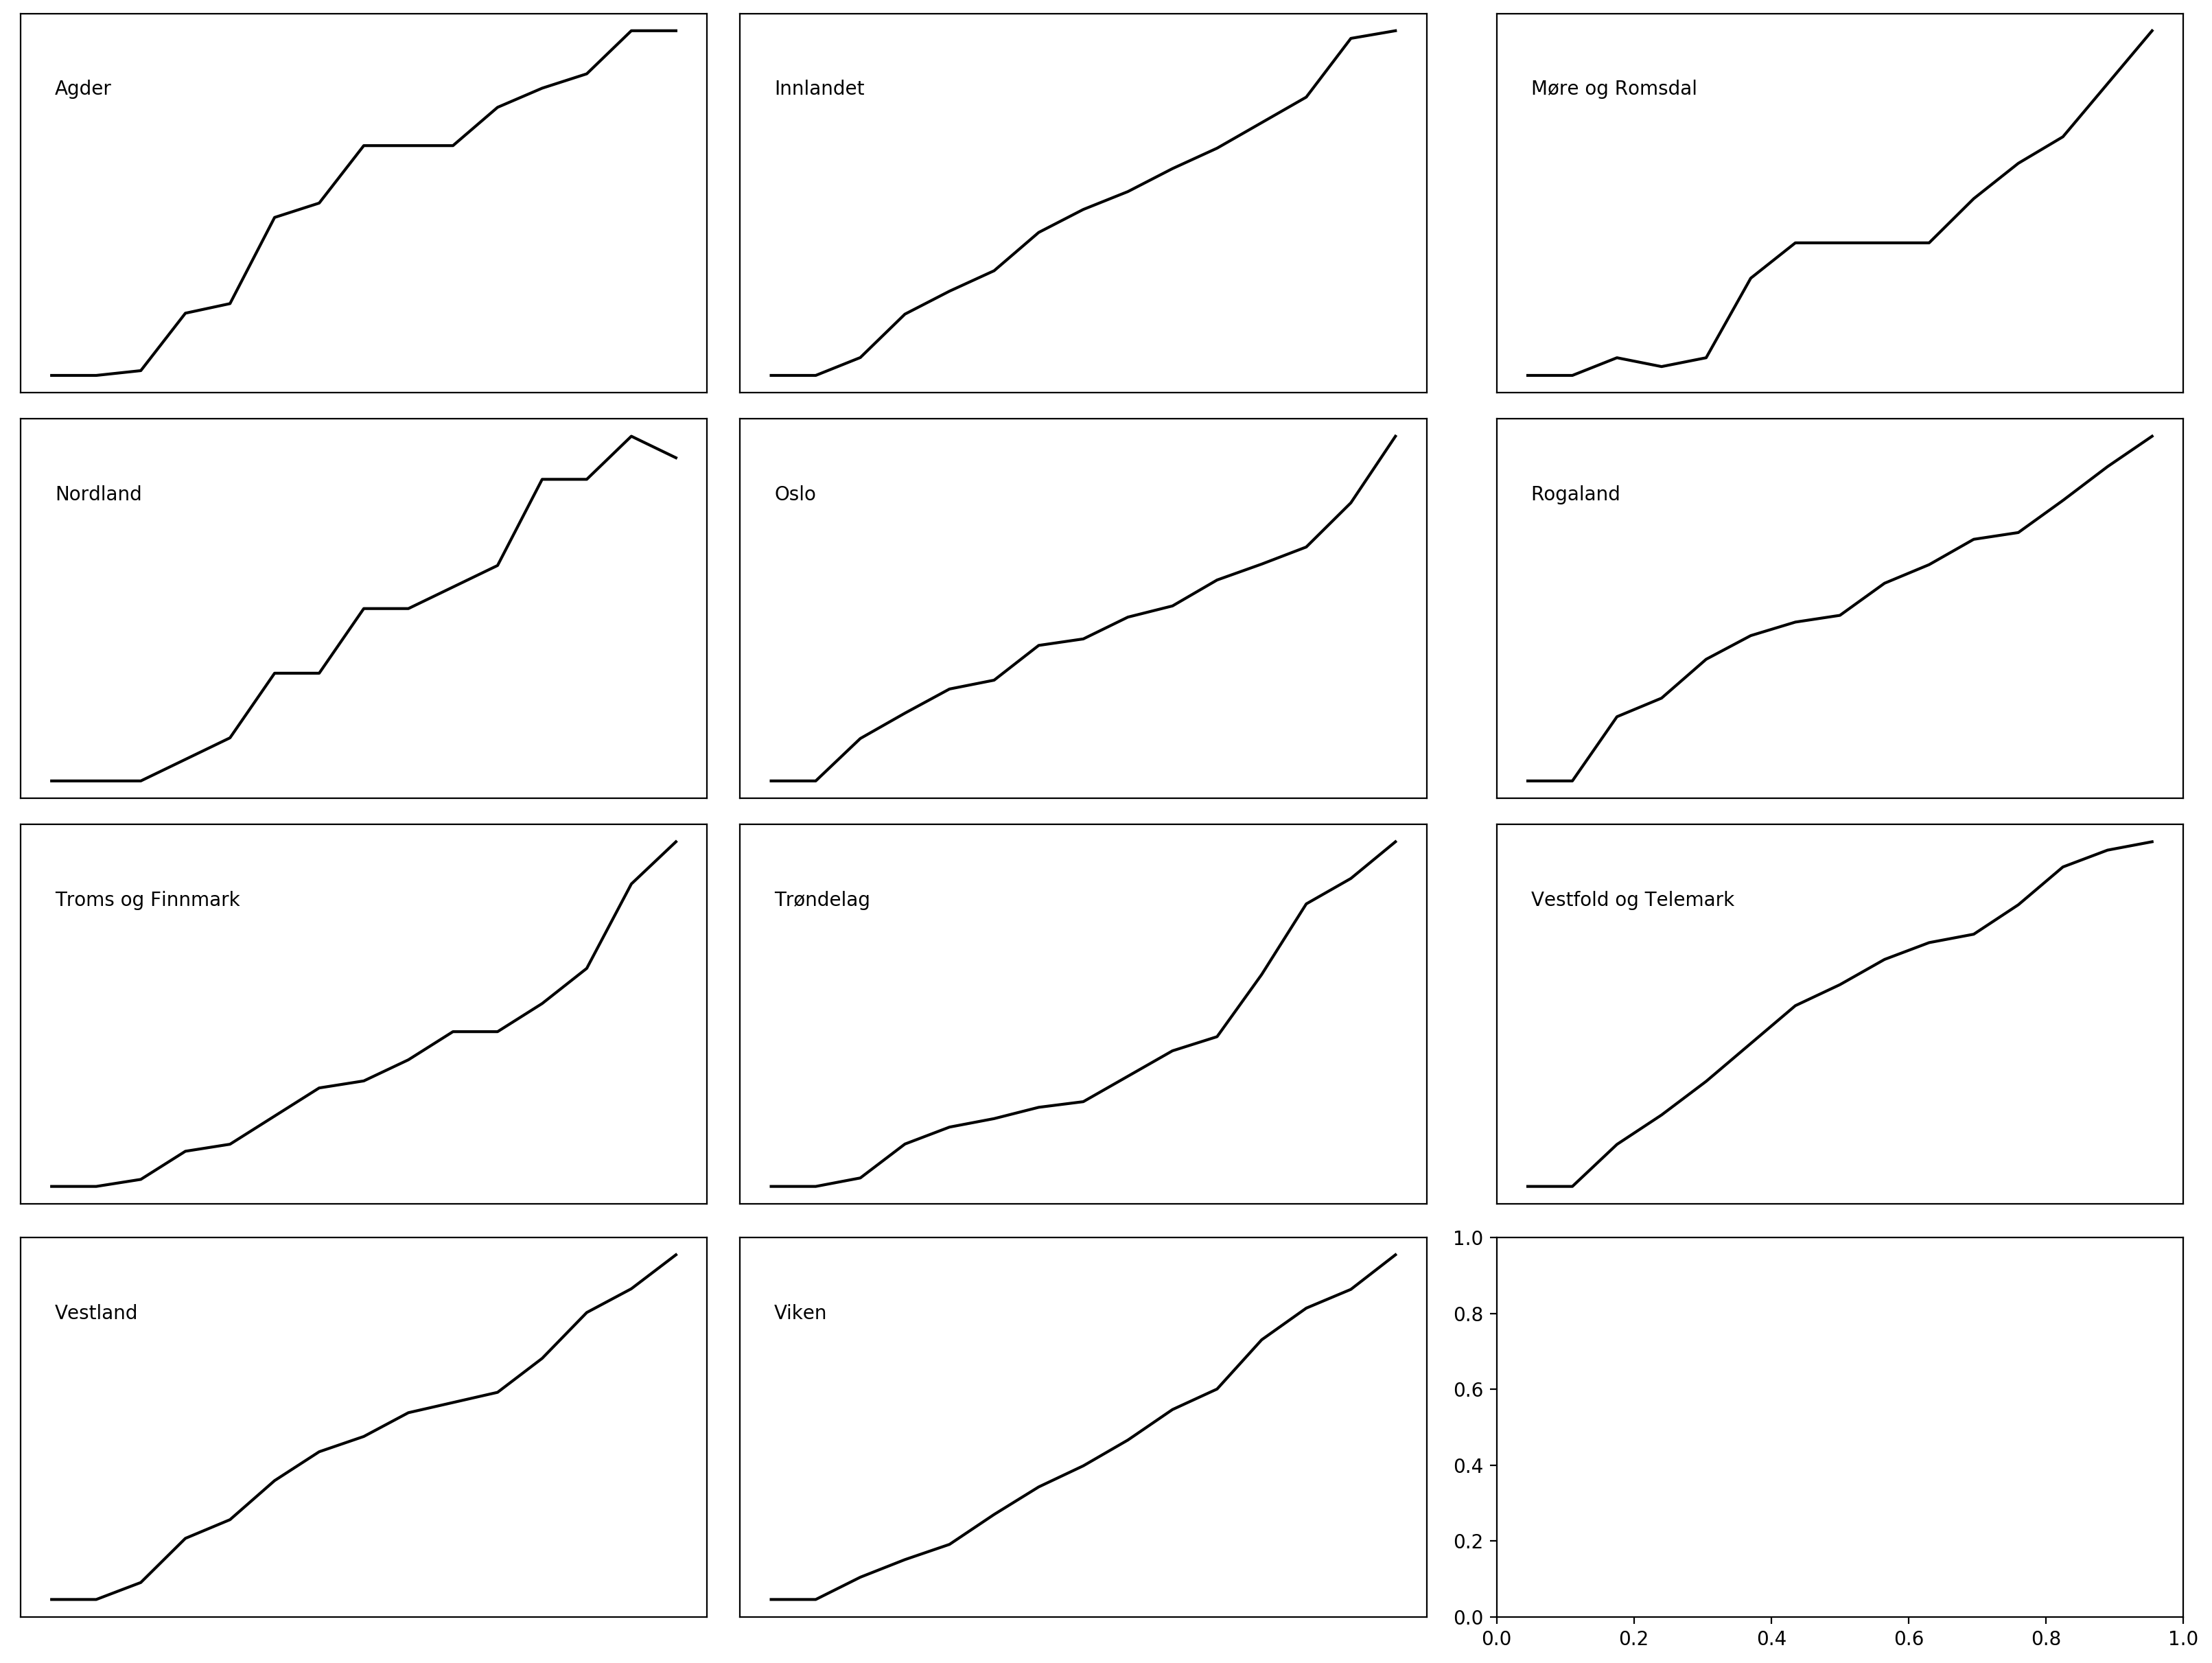

In [427]:
fig = plt.figure(figsize=(16,12), dpi=200, constrained_layout=True)

axs = fig.subplots(nrows=4, ncols=3)

for i in range(len(df.columns)):
    axs.flat[i].plot(df.index, df.iloc[:,i], color='black')
    axs.flat[i].get_xaxis().set_ticks([])
    axs.flat[i].get_yaxis().set_ticks([])
    axs.flat[i].annotate(df.iloc[:,i].name, (0.05, 0.8),xycoords='axes fraction', va='center', ha='left')
    
fig.savefig('fylker_matrix.png')

In [428]:
unstacked = df.unstack().reset_index()

unstacked = unstacked[pd.to_datetime(unstacked["variable"]) >= pd.to_datetime("2020-02-25")]

unstacked.head()

,Fylke,variable,0
0,Agder,2020-03-09,19
1,Agder,2020-03-10,19
2,Agder,2020-03-11,20
3,Agder,2020-03-12,32
4,Agder,2020-03-13,34


In [429]:
import plotly.express as px
fig = px.scatter(unstacked, x="variable", y=0, color="Fylke")
fig.update_traces(mode="markers+lines")


# moment

In [430]:
roc = df.copy()
roc = roc.pct_change(periods=2)*100/3

roc.iloc[[-1]].melt()
roc1 = roc.iloc[[-1]].melt().rename(columns={"value": "Vekstrate"}).sort_values(by=['Vekstrate'], ascending=True)
lastweek = roc.iloc[[-7]].melt().rename(columns={"value": "- 1 uke"})

vekst = roc1.merge(lastweek, how="left", on="Fylke")
vekst.head()

,Fylke,Vekstrate,- 1 uke
0,Nordland,1.960784,12.500000
1,Vestfold og Telemark,2.469136,7.638889
2,Agder,3.658537,7.272727
3,Viken,5.202973,9.592326
4,Vestland,5.666667,6.497175


In [431]:
vekst["dtime"] = np.log(2)/np.log(1+(vekst["Vekstrate"]/100))
#vekst["dtime"] = (72/(vekst["Vekstrate"]))
vekst["momentum"] = vekst["Vekstrate"]-vekst["- 1 uke"]
vekst["momentum"] = vekst["momentum"].apply(lambda x: "Avtagende" if x < 0 else "Tiltagende")
vekst["text"] = "Hver "+vekst["dtime"].round(0).astype(str)+" dag"
vekst["Vekstrate"] = vekst["Vekstrate"].round(2)
vekst["- 1 uke"] = vekst["- 1 uke"].round(2)
vekst = vekst.merge(fylker, how="left", on="Fylke")

vekst

,Fylke,Vekstrate,- 1 uke,dtime,momentum,text,RHF,Befolkning
0,Nordland,1.96,12.50,35.695958,Avtagende,Hver 36.0 dag,Helse Nord,241235
1,Vestfold og Telemark,2.47,7.64,28.417626,Avtagende,Hver 28.0 dag,Helse Sør-Øst,419396
2,Agder,3.66,7.27,19.290521,Avtagende,Hver 19.0 dag,Helse Sør-Øst,307231
3,Viken,5.20,9.59,13.665780,Avtagende,Hver 14.0 dag,Helse Sør-Øst,1241165
4,Vestland,5.67,6.50,12.575399,Avtagende,Hver 13.0 dag,Helse Vest,636531
5,Trøndelag,6.01,7.33,11.874651,Avtagende,Hver 12.0 dag,Helse Midt-Norge,468702
6,Rogaland,6.37,6.04,11.232716,Tiltagende,Hver 11.0 dag,Helse Vest,479892
7,Innlandet,6.93,7.41,10.340017,Avtagende,Hver 10.0 dag,Helse Sør-Øst,371385
8,Møre og Romsdal,12.50,0.00,5.884949,Tiltagende,Hver 6.0 dag,Helse Midt-Norge,265238
9,Oslo,13.99,5.69,5.294278,Tiltagende,Hver 5.0 dag,Helse Sør-Øst,693494


In [432]:
from datetime import datetime

legend = [i for i in vekst["RHF"].unique()]
legend.sort()

fig = px.bar(vekst, 
             x='Vekstrate', y='Fylke', 
             orientation='h',
             category_orders={"RHF": legend},
             height=500,
             title = "<b>Endringer i antall registrerte smittede pr fylke</b><br>Gjennomsnittlig veksttakt siste tre dager<br>Datakilde: FHI - folkehelseinstituttet. Oppdatert " +datetime.today().strftime('%d.%m.%Y'),
             color='RHF',
             text="text",
             hover_name="Fylke",
             hover_data=["Vekstrate"],
             template = "plotly_white", 
             labels = {"Vekstrate": "daglig vekst (%)", "- 1 uke": "Daglig vekst for en uke siden", "text": "Dager før dobling med dagens vekst"},
            )

"""
fig.add_shape(
        # doubling time 2 days
        dict(
            type="line",
            x0=41.42136,
            y0=-0.5,
            x1=41.42136,
            y1=21.5,
            line=dict(
                color="Black",
                width=1
            )))
fig.add_shape(
        # doubling time 1 uke
        dict(
            type="line",
            x0=10.40895,
            y0=-0.5,
            x1=10.40895,
            y1=21.5,
            line=dict(
                color="Black",
                width=1
            )))

"""
fig.layout.coloraxis.showscale = False

fig.update_layout(
    yaxis=dict(
        separatethousands=True,
        categoryorder = 'total ascending',
        title_text="",
        fixedrange=True,
    ), xaxis=dict(fixedrange=True,
                 title_text=""),
    title_font=dict(family="Helvetica", size=18),
        margin=dict(b=150)) #bottom margin

fig.update_layout(autosize=True,
    margin=dict(l=100, r=100, t=150, b=0),
    paper_bgcolor='rgba(0, 0, 0, 0)'
    #plot_bgcolor='rgb(248, 248, 255)'    
                 )

#plotly.offline.plot(fig, filename='COVID_moment_fylke.html')
py.plot(fig, filename='COVID19_vekstmomentum_fylker.html')

'https://plotly.com/~oystein.nerva/58/'

# animation

In [433]:
melted = pd.melt(df.reset_index(), id_vars=["variable"], var_name="Fylke", value_name="Registrerte smittede").dropna().sort_values(by=["variable"])
melted["variable"] = melted["variable"].apply(lambda x: x.strftime("%d %b"))
melted = melted.merge(fylker, how="left", on="Fylke")
melted["Smittede/tusen innb"] = melted["Registrerte smittede"]/(melted["Befolkning"]/1000)
melted["txt"] = melted["Smittede/tusen innb"].round(2).astype(str)
melted.head()

,variable,Fylke,Registrerte smittede,RHF,Befolkning,Smittede/tusen innb,txt
0,09 Mar,Agder,19,Helse Sør-Øst,307231,0.061843,0.06
1,09 Mar,Vestland,31,Helse Vest,636531,0.048701,0.05
2,09 Mar,Nordland,3,Helse Nord,241235,0.012436,0.01
3,09 Mar,Vestfold og Telemark,5,Helse Sør-Øst,419396,0.011922,0.01
4,09 Mar,Møre og Romsdal,5,Helse Midt-Norge,265238,0.018851,0.02


In [434]:
legend = [i for i in vekst["RHF"].unique()]
legend.sort()

fig = px.bar(melted, 
             x='Registrerte smittede', y='Fylke', animation_frame="variable",
             animation_group="Fylke",
             orientation='h',
             category_orders={"RHF": legend},
             labels = {"Veksttakt": "daglig vekst (%)", "variable": "Dato"},
             color='RHF',
             text="Registrerte smittede",
             height=600,
             title = "<b>COVID19: Registrert smittet i Norge</b><br>Fordeling per fylke<br>Datakilde: FHI - folkehelseinstituttet. Oppdatert " +datetime.today().strftime('%d.%m.%Y'),
             template = "plotly_white",
             range_x=[0,600]
                 ).update_yaxes(categoryorder="total ascending")

fig.layout.coloraxis.showscale = False

fig.update_layout(
    yaxis=dict(
        separatethousands=True,
        categoryorder = 'total ascending',
        title_text="",
        fixedrange=True,
    ), xaxis=dict(fixedrange=True,
                 title_text=""),
    title_font=dict(family="Helvetica", size=18),
        margin=dict(b=150)) #bottom margin

fig.update_layout(autosize=True,
    margin=dict(l=100, r=100, t=150, b=0),
    paper_bgcolor='rgba(0, 0, 0, 0)'
    #plot_bgcolor='rgb(248, 248, 255)'    
                 )

#plotly.offline.plot(fig, filename='COVID19_fylkesutvikling_animation.html')
py.plot(fig, filename='COVID19_fylkesutvikling_animation.html')
fig.show()

In [438]:
legend = [i for i in vekst["RHF"].unique()]
legend.sort()

fig = px.bar(melted, 
             x='Smittede/tusen innb', y='Fylke', animation_frame="variable",
             animation_group="Fylke",
             orientation='h',
             category_orders={"RHF": legend},
             labels = {"Veksttakt": "daglig vekst (%)", "variable": "Dato"},
             color='RHF',
             text="txt",
             height=600,
             title = "<b>COVID19: Registrert smittet i Norge</b><br>Antall smittet per 1 000 innbyggere<br>Datakilde: FHI - folkehelseinstituttet. Oppdatert " +datetime.today().strftime('%d.%m.%Y'),
             template = "plotly_white",
             range_x=[0,1]
                 ).update_yaxes(categoryorder="total ascending")

fig.layout.coloraxis.showscale = False

fig.update_layout(
    yaxis=dict(
        separatethousands=True,
        categoryorder = 'total ascending',
        title_text="",
        fixedrange=True,
    ), xaxis=dict(fixedrange=True,
                 title_text="per 1 000"),
    title_font=dict(family="Helvetica", size=18),
        margin=dict(b=150)) #bottom margin

fig.update_layout(autosize=True,
    margin=dict(l=100, r=100, t=150, b=0),
    paper_bgcolor='rgba(0, 0, 0, 0)'
    #plot_bgcolor='rgb(248, 248, 255)'    
                 )

py.plot(fig, filename='COVID19_per_capita_fylkesutvikling_animation.html')
fig.show()